In [1]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score
from scipy.sparse import csr_matrix,hstack
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import pickle
import sys 
sys.path.append("../../")
from E4525_ML import text

In [2]:
class CombinedNB(BaseEstimator):
    def __init__(self,n1,n2,n3,a):
        self.n1=n1
        self.n2=n2
        self.n3=n3
        self.a=a
    
    def fit(self,X,y):
        self.model1=MultinomialNB(alpha=self.a)
        self.model1.fit(X[:,:self.n1],y)
        self.class_prior_=self.model1.class_count_/self.model1.class_count_.sum()
        
        self.model2=MultinomialNB(alpha=self.a)
        self.model2.fit(X[:,self.n1:(self.n1+self.n2)],y)
        self.model3=MultinomialNB(alpha=self.a)
        self.model3.fit(X[:,(self.n1+self.n2):(self.n1+self.n2+self.n3)],y)
        
    def predict_proba(self,X):
        p1=self.model1.predict_proba(X[:,:self.n1])
        p2=self.model2.predict_proba(X[:,self.n1:(self.n1+self.n2)])
        p3=self.model3.predict_proba(X[:,(self.n1+self.n2):(self.n1+self.n2+self.n3)])
        p=p1*p2*p3/(self.class_prior_*self.class_prior_)
        return p/p.sum(axis=1)[:,np.newaxis]
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1)

(35288, 4) (35288, 36750) (35288, 575000)
auc on test set is 0.9664642196795578
Accuracy on test set is 0.9164305146225346


<Figure size 432x288 with 0 Axes>

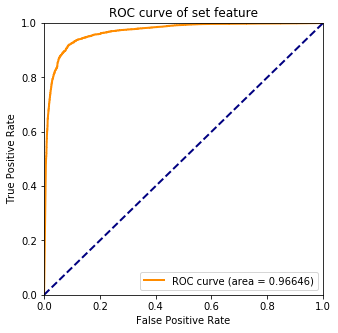

(35288, 4) (35288, 36750) (35288, 575000)
auc on test set is 0.9287907339174915
Accuracy on test set is 0.8774087508501474


<Figure size 432x288 with 0 Axes>

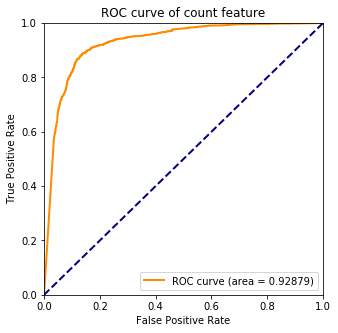

(35288, 4) (35288, 36750) (35288, 575116)
auc on test set is 0.9643243174667213
Accuracy on test set is 0.8941283155746996


<Figure size 432x288 with 0 Axes>

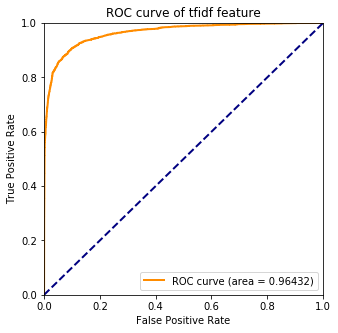

In [7]:
def combined_model_test(feature="tfidf",n=-1,model_type="MB"):
    
    # load message body features
    data_dir = "message_feature"

    set_features_filename=     data_dir+"/{}_features06.p".format(feature)
    labels_filename=     data_dir+"/labels06.p"

    X_set_body=pickle.load(open( set_features_filename, "rb" ) )
    labels=pickle.load(open( labels_filename, "rb" ) )
    
    if n!=-1:
        labels=labels[:n]
        X_set_body=X_set_body[:n]
    
    # load subject features
    data_dir = "subject_feature"

    set_features_filename=     data_dir+"/{}_features06.p".format(feature)
    labels_filename=     data_dir+"/labels06.p"

    # setVectorizer_subject=pickle.load(open( set_vectorizer_filename, "rb" ) )
    X_set_subject=pickle.load(open( set_features_filename, "rb" ) )
    
    if n!=-1:
        X_set_subject=X_set_subject[:n]
    
    # load structural info features
    StructuralInfo=pd.read_csv("email_06_structure.csv",index_col=[0])
    StructuralInfo=StructuralInfo.iloc[:,:-1]
    if n!=-1:
        StructuralInfo=StructuralInfo.values[:n]
    
    StructuralInfo=csr_matrix(StructuralInfo)
    
    print(StructuralInfo.shape,X_set_subject.shape,X_set_body.shape)
    
    # Combine features together
    X_set=csr_matrix(hstack([X_set_body,X_set_subject,StructuralInfo]))
    
    with open("./models/CombinedFeatNB_{}.p".format(feature),"rb") as f:
        model=pickle.load(f)
        
    Y_pred=model.predict_proba(X_set)
    print("auc on test set is",roc_auc_score(labels,Y_pred[:,1]))
    print("Accuracy on test set is",np.mean(model.predict(X_set)==labels))
    
    fpr,tpr,threshold = roc_curve(labels,Y_pred[:,1])
    roc_auc = auc(fpr,tpr)

    plt.figure()
    lw = 2
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.5f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of {} feature'.format(feature))
    plt.legend(loc="lower right")
    plt.savefig("roc_curve_{}.png".format(feature))
    plt.show()
    
combined_model_test("set")
combined_model_test("count")
combined_model_test("tfidf")